16:45:30 - cmdstanpy - INFO - Chain [1] start processing
16:45:31 - cmdstanpy - INFO - Chain [1] done processing


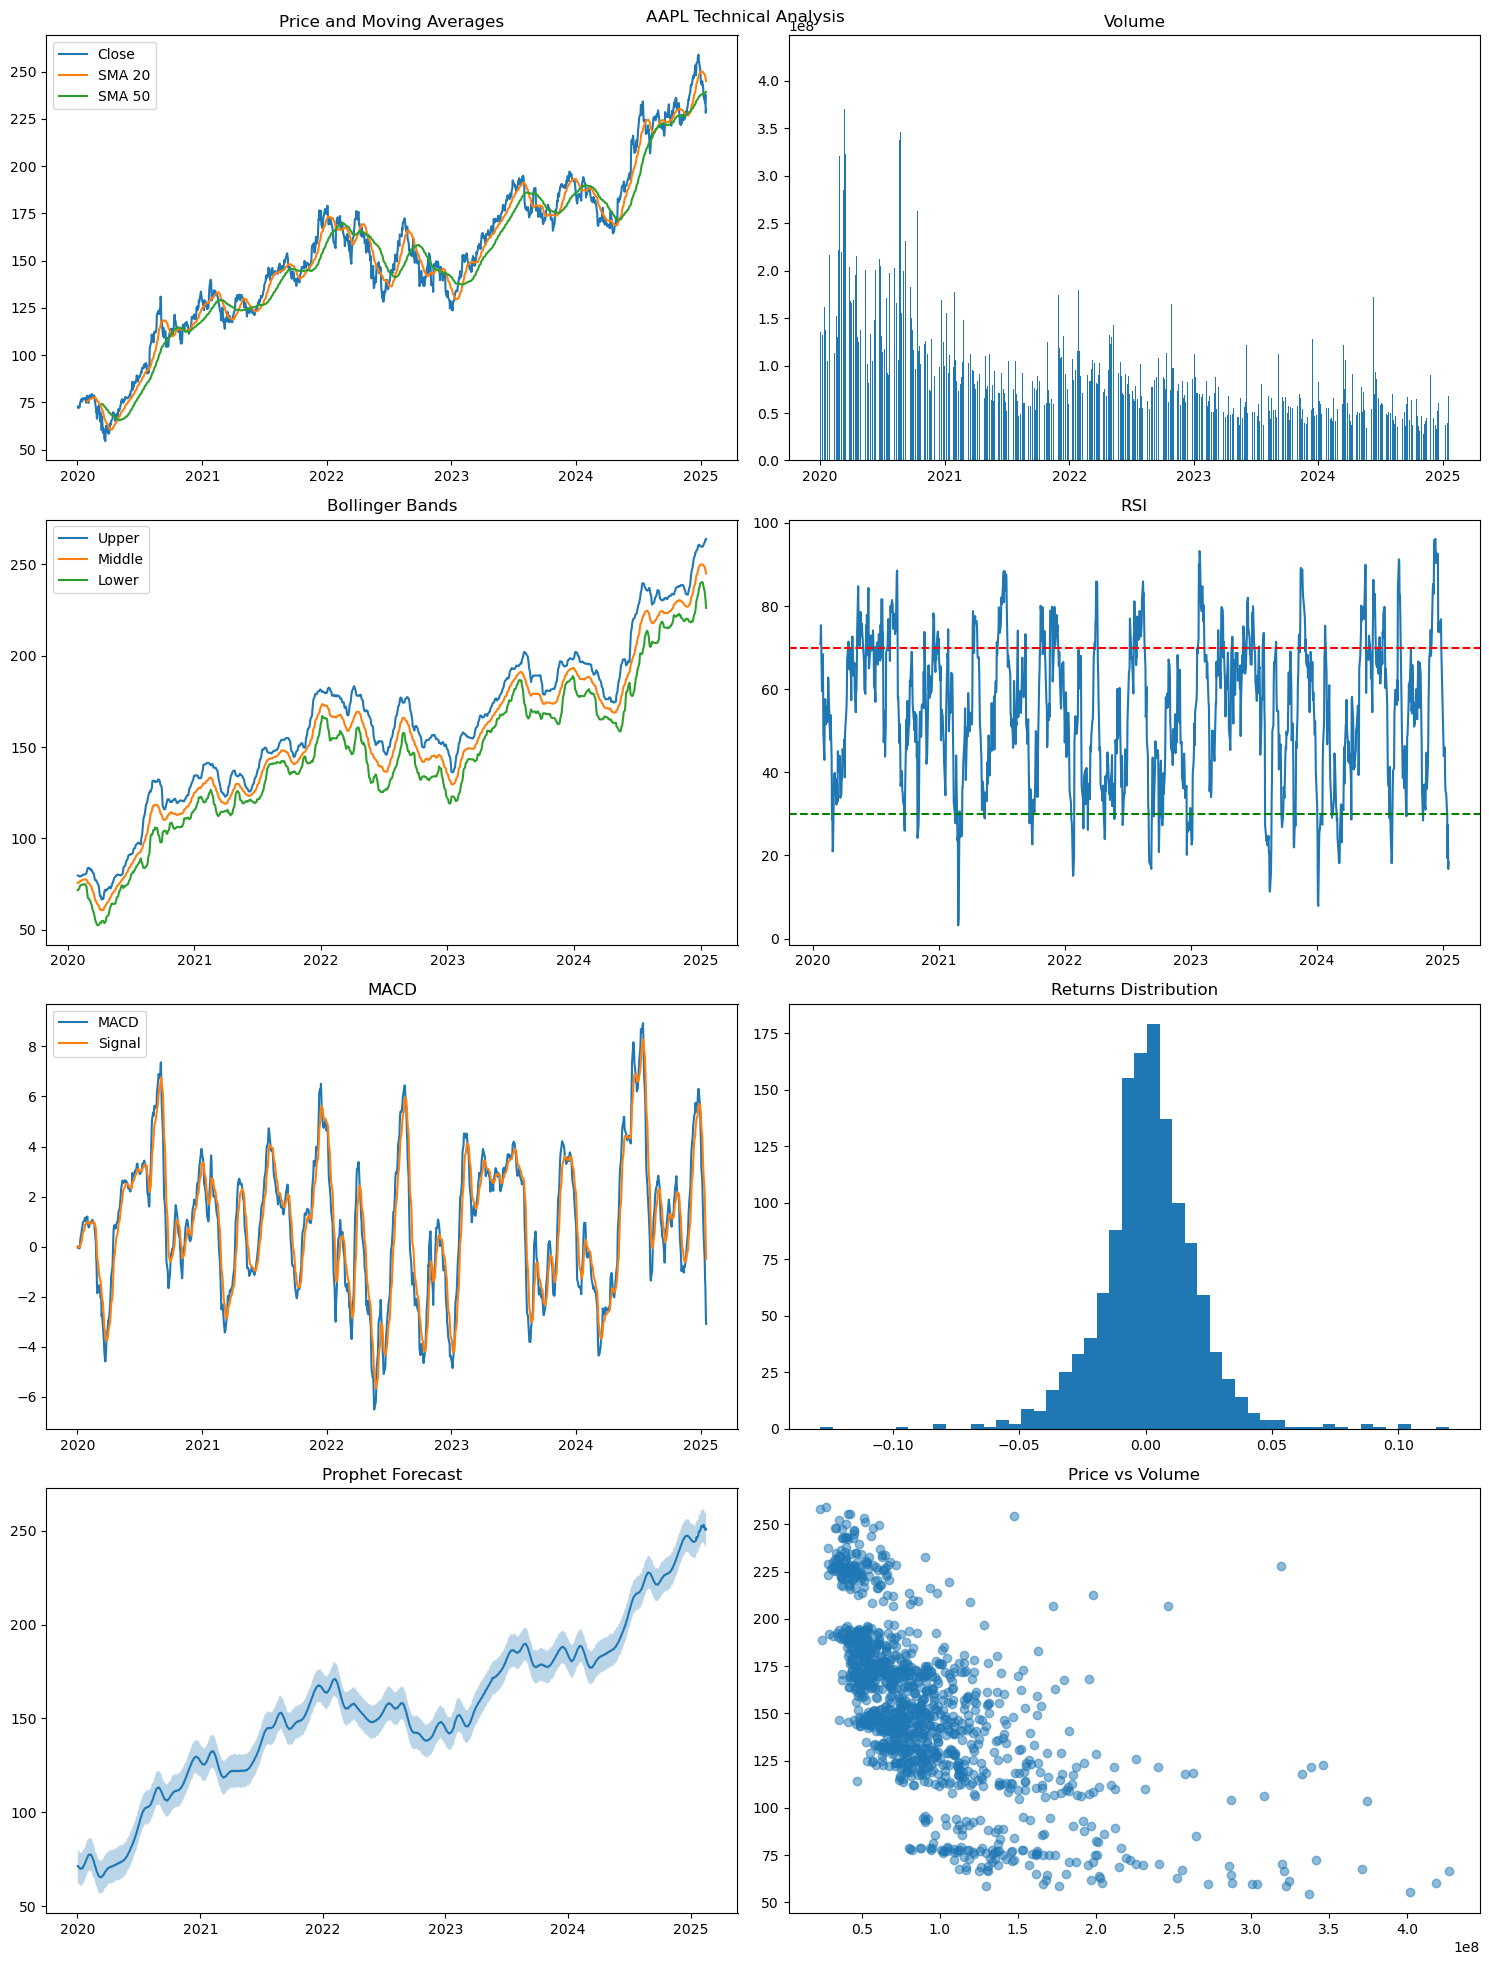

16:45:35 - cmdstanpy - INFO - Chain [1] start processing
16:45:35 - cmdstanpy - INFO - Chain [1] done processing


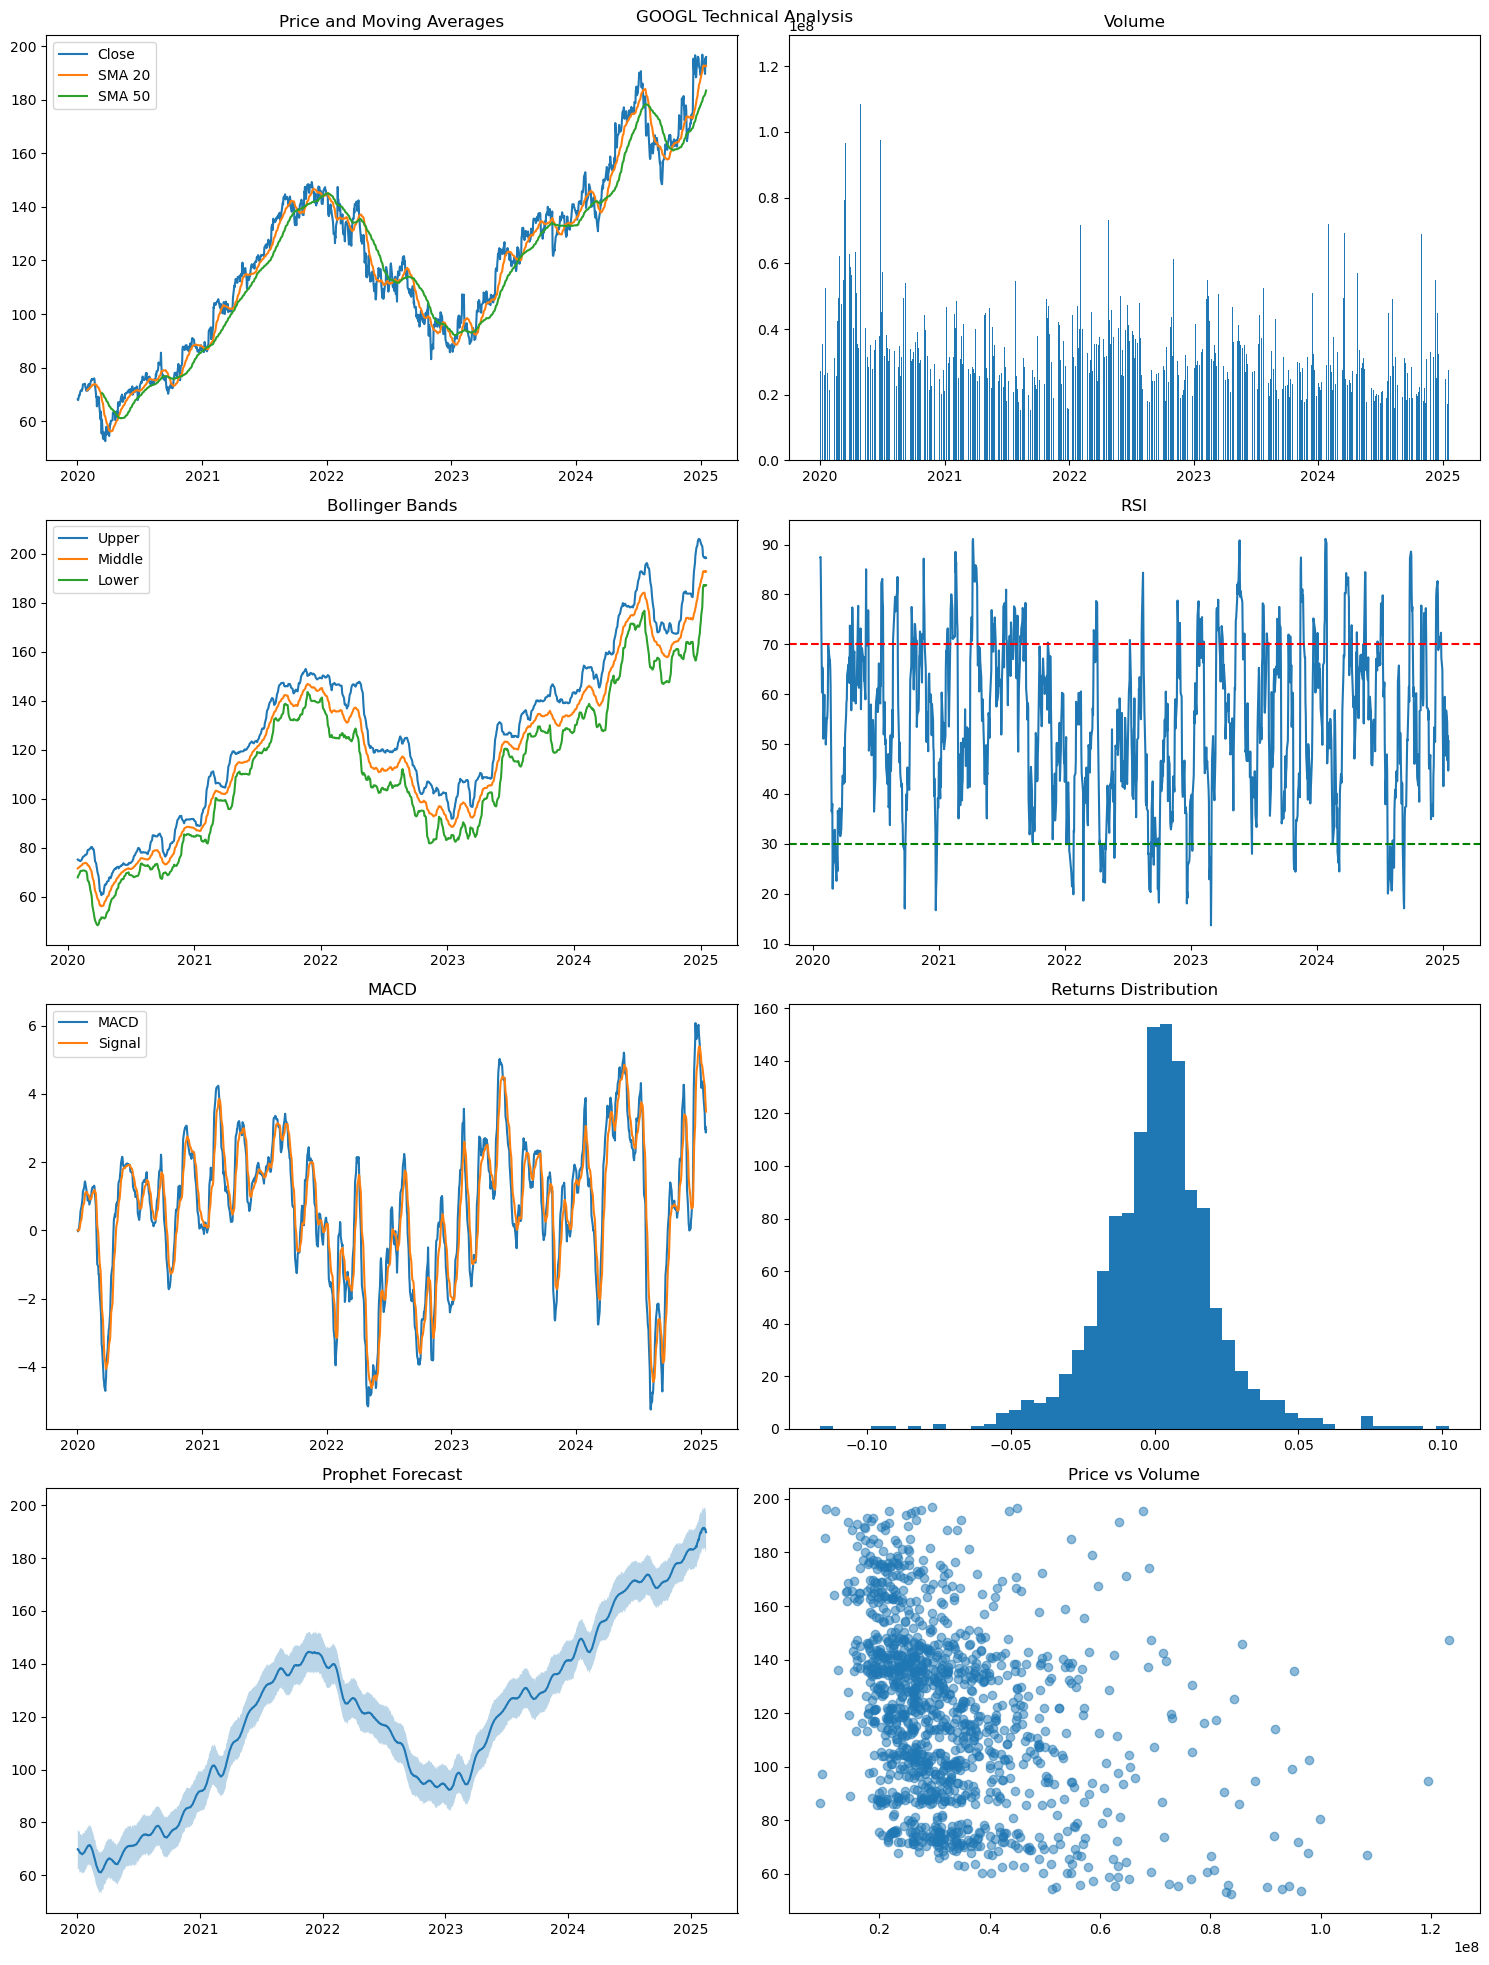

16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:39 - cmdstanpy - INFO - Chain [1] done processing


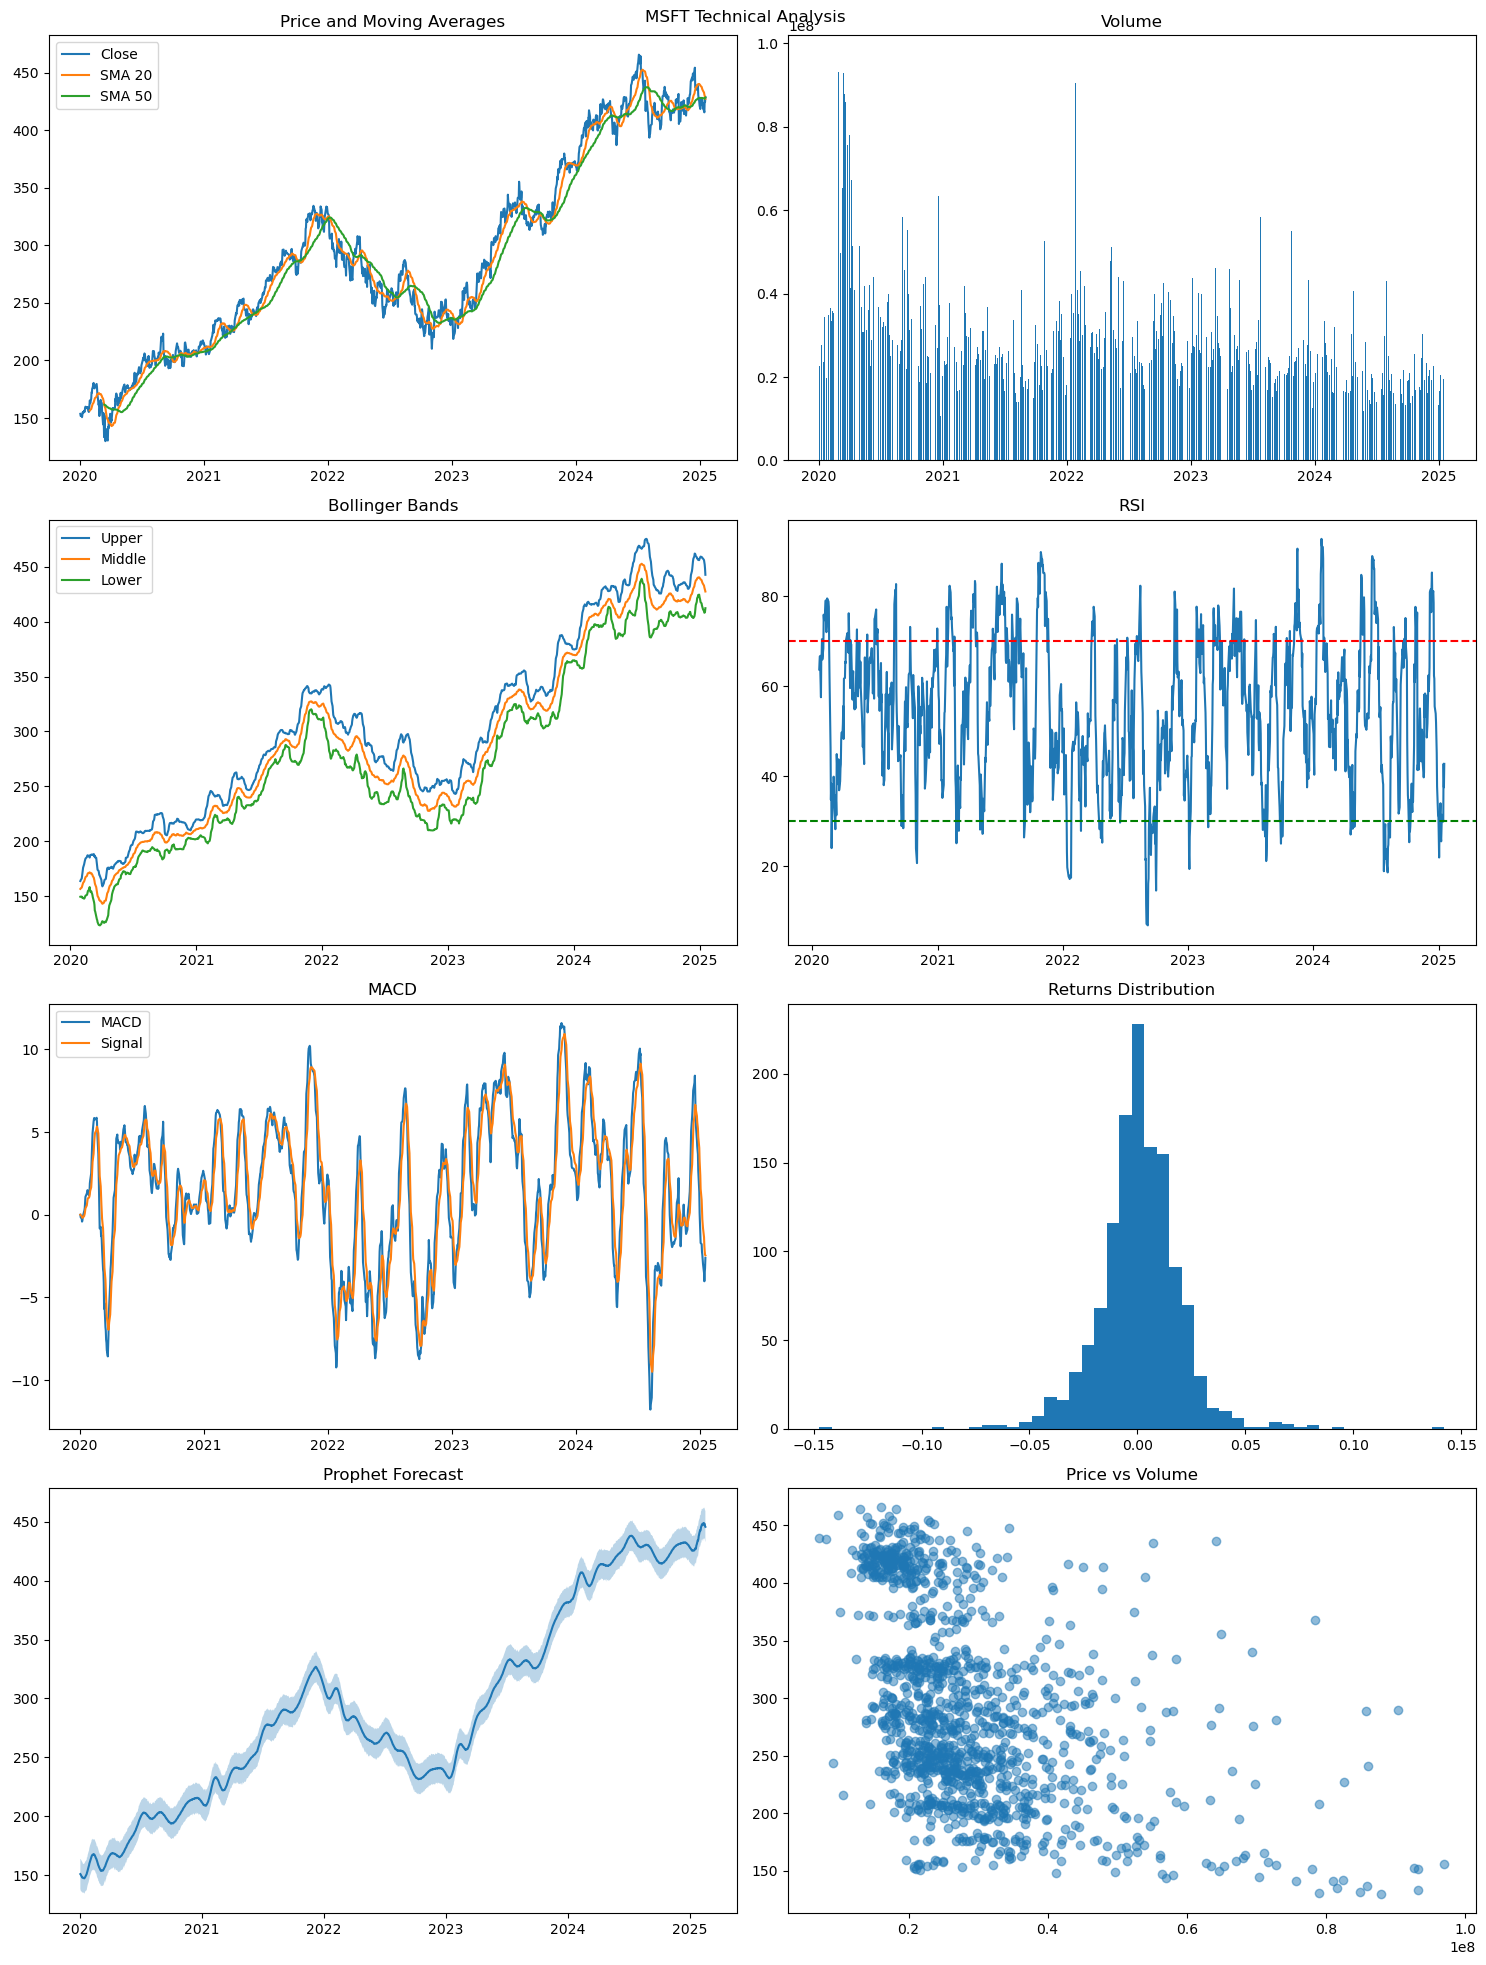

16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:44 - cmdstanpy - INFO - Chain [1] done processing


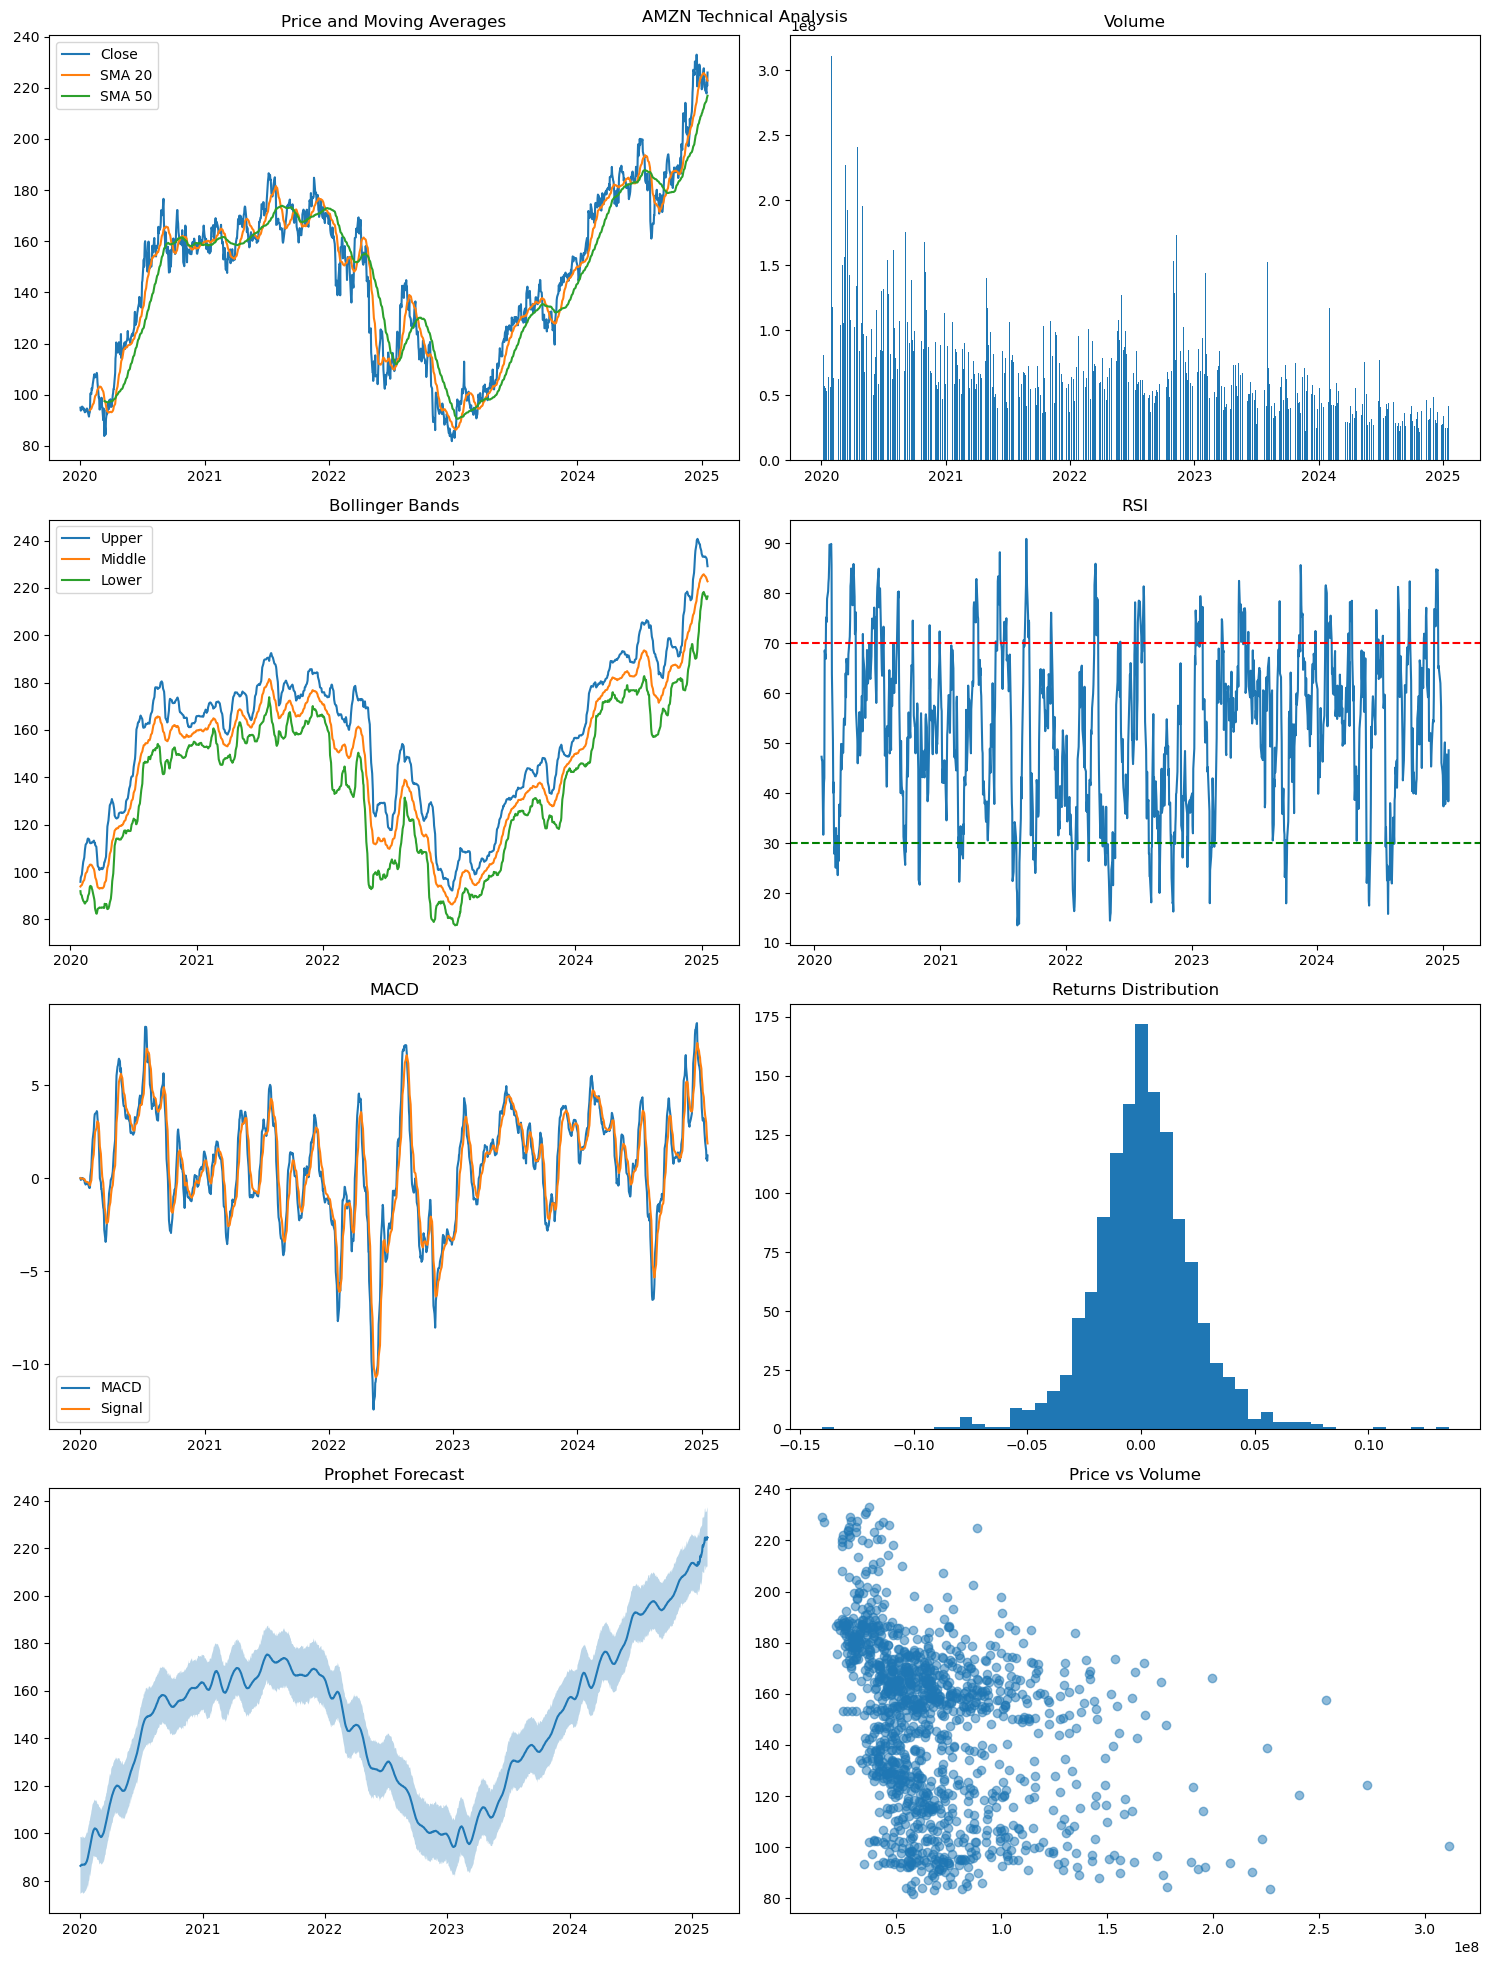

16:45:48 - cmdstanpy - INFO - Chain [1] start processing
16:45:49 - cmdstanpy - INFO - Chain [1] done processing


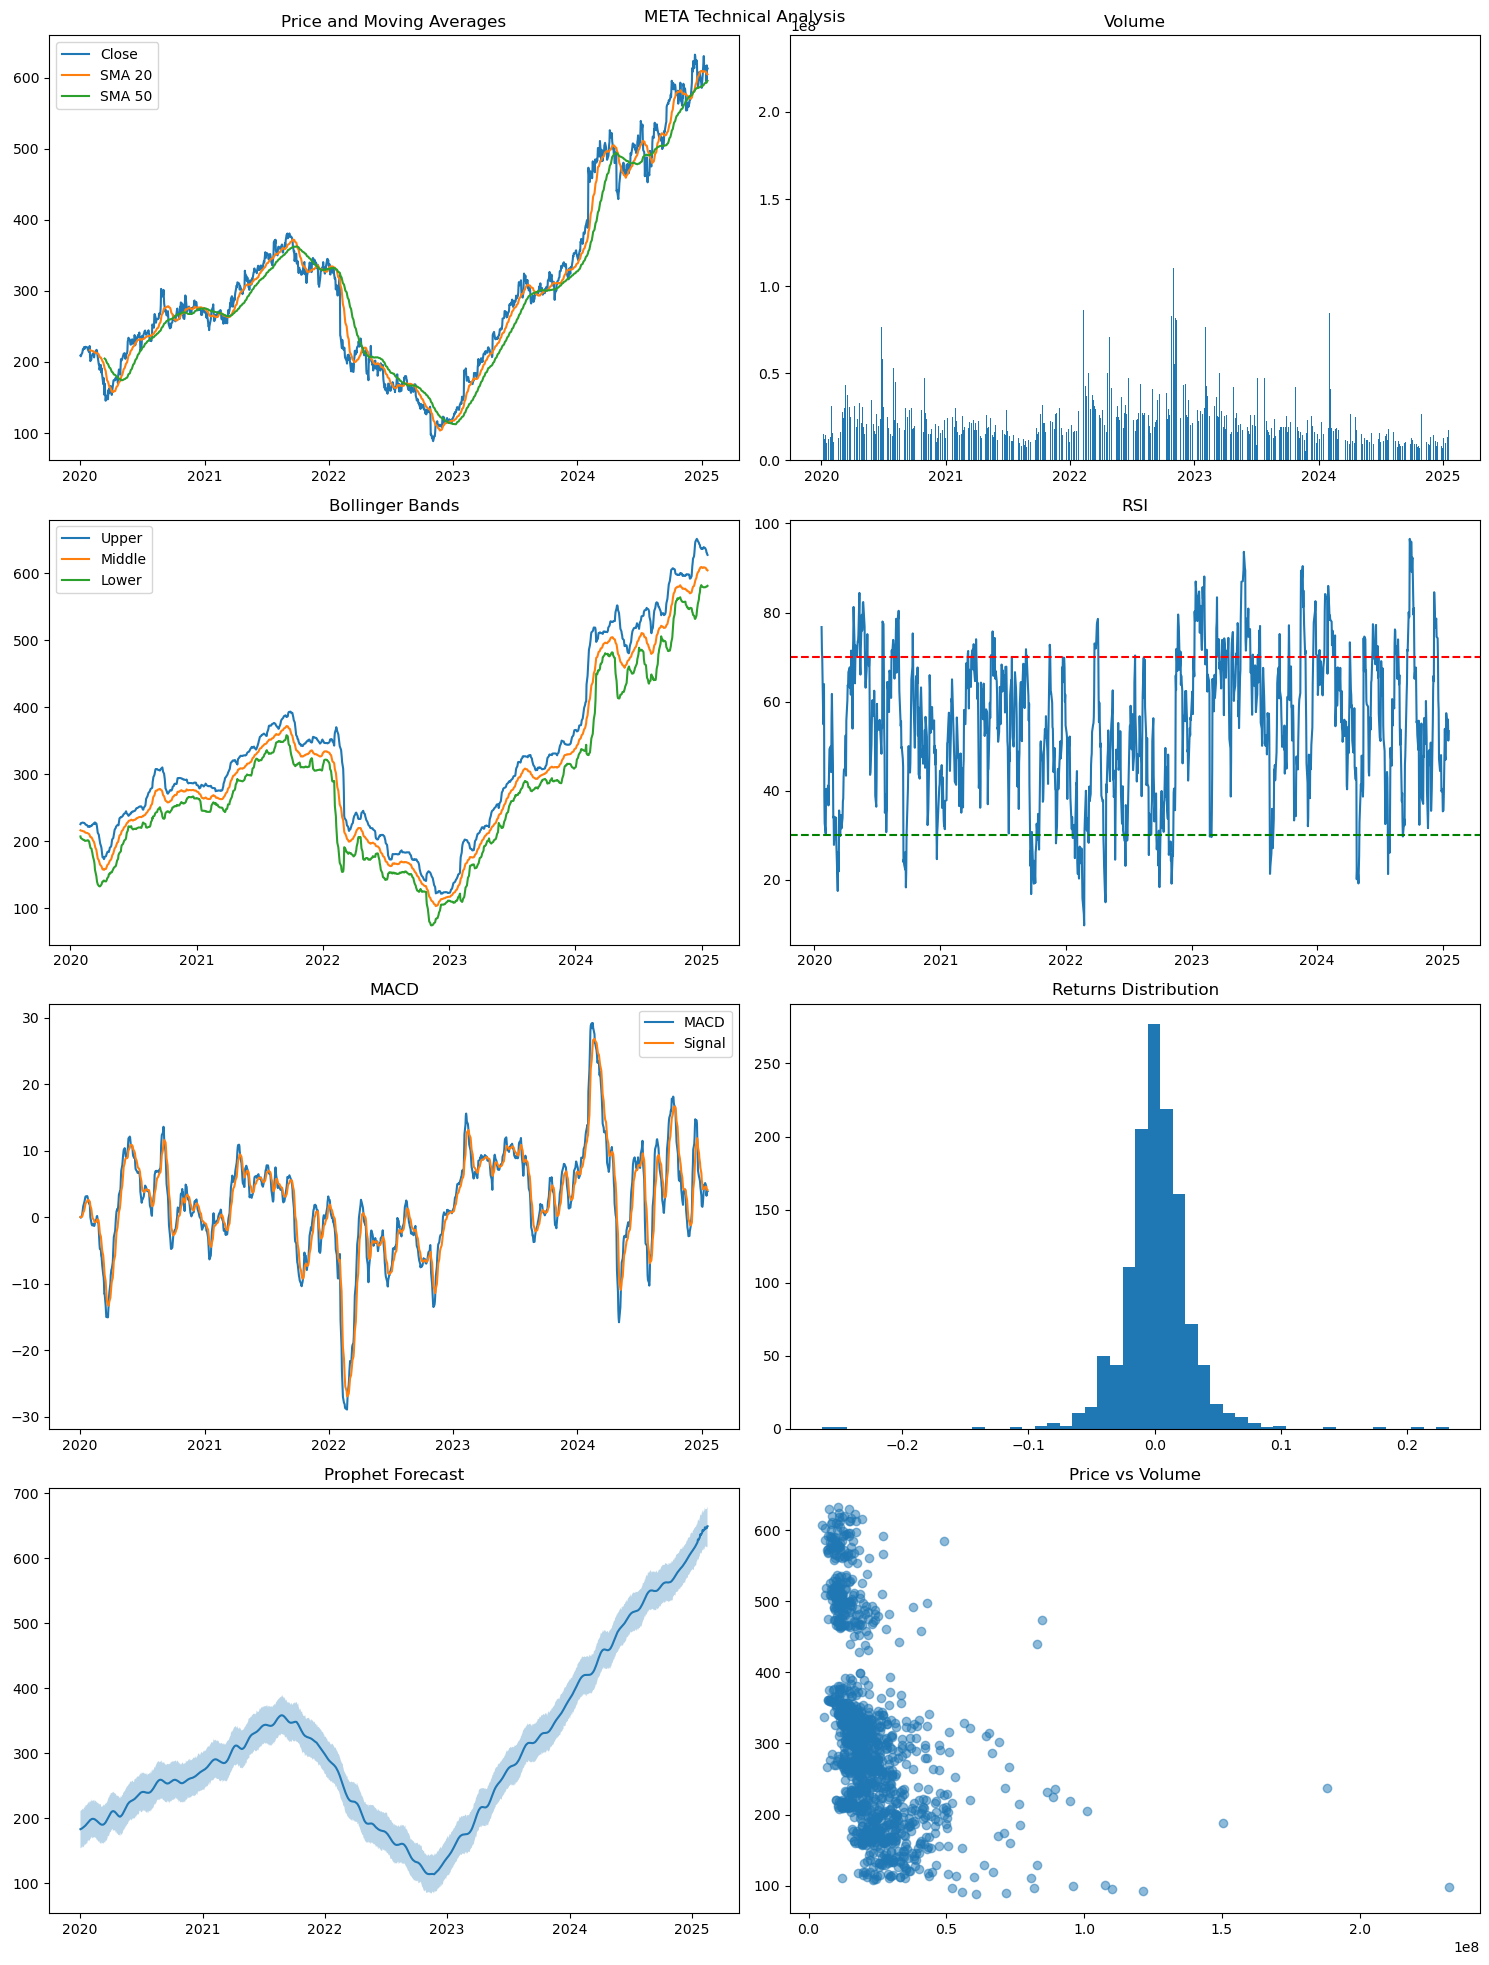

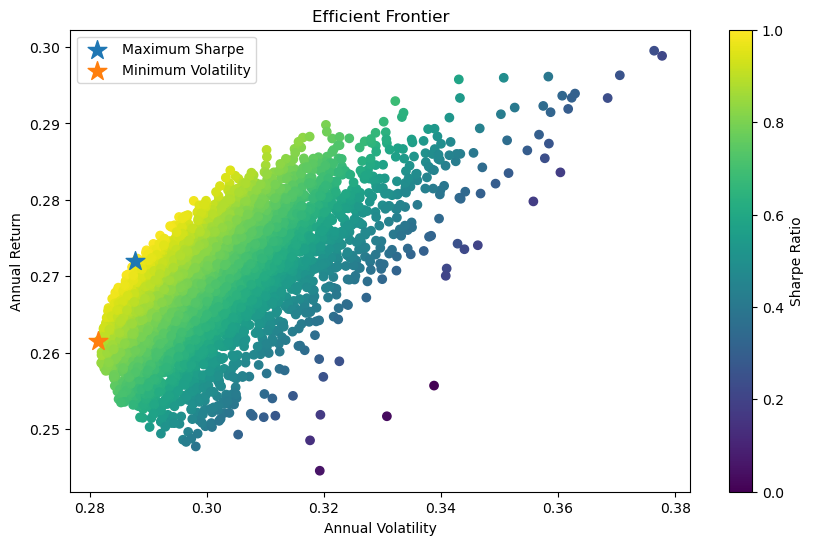


Portfolio Metrics:
       Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  \
AAPL        0.278755           0.316624      0.880399     -0.314273   
GOOGL       0.262535           0.324338      0.809450     -0.443201   
MSFT        0.250435           0.304118      0.823482     -0.371485   
AMZN        0.236759           0.358826      0.659816     -0.561453   
META        0.315561           0.448195      0.704071     -0.767361   

       Sortino Ratio  Value at Risk  
AAPL        1.205070      -0.030316  
GOOGL       1.092463      -0.030927  
MSFT        1.097520      -0.028418  
AMZN        0.924911      -0.033072  
META        0.887505      -0.040129  

Optimal Portfolios:
{'Maximum Sharpe': std       0.287734
ret       0.271974
sharpe    0.910472
AAPL      0.517900
GOOGL     0.247759
MSFT      0.165929
AMZN      0.007377
META      0.061035
Name: 4187, dtype: float64, 'Minimum Volatility': std       0.281479
ret       0.261565
sharpe    0.893726
AAPL      0.330496
GOOGL  

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from scipy import stats
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class StockAnalysis:
    def __init__(self, symbols, start_date, end_date):
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.data = {}
        self.detailed_data = {}
        self.prophet_forecasts = {}

    def fetch_stock_data(self):
        """Fetch historical stock data and detailed info"""
        for symbol in self.symbols:
            stock = yf.Ticker(symbol)
            
            # Historical data
            hist = stock.history(start=self.start_date, end=self.end_date)
            self.data[symbol] = hist
            
            # Detailed data
            info = stock.info
            self.detailed_data[symbol] = {
                'fundamentals': {
                    'Market Cap': info.get('marketCap'),
                    'Forward P/E': info.get('forwardPE'),
                    'PEG Ratio': info.get('pegRatio'),
                    'Price to Book': info.get('priceToBook'),
                    'Dividend Yield': info.get('dividendYield'),
                    'Beta': info.get('beta'),
                    'EPS': info.get('trailingEps'),
                    'ROE': info.get('returnOnEquity'),
                    'Profit Margins': info.get('profitMargins')
                },
                'institutional_holders': stock.institutional_holders,
                'recommendations': stock.recommendations,
                'earnings': stock.earnings_dates,
                'news': stock.news
            }

    def calculate_technical_indicators(self, symbol):
        """Calculate technical indicators for a given stock"""
        df = self.data[symbol].copy()
        
        # Moving averages
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['SMA_200'] = df['Close'].rolling(window=200).mean()
        
        # Bollinger Bands
        df['BB_middle'] = df['Close'].rolling(window=20).mean()
        df['BB_upper'] = df['BB_middle'] + 2*df['Close'].rolling(window=20).std()
        df['BB_lower'] = df['BB_middle'] - 2*df['Close'].rolling(window=20).std()
        
        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        # MACD
        exp1 = df['Close'].ewm(span=12, adjust=False).mean()
        exp2 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
        
        return df

    def run_prophet_forecast(self, symbol, periods=30):
        """Generate Prophet forecasts"""
        df = self.data[symbol].reset_index()
        # Remove timezone from datetime
        df['Date'] = df['Date'].dt.tz_localize(None)
        prophet_df = pd.DataFrame({
            'ds': df['Date'],
            'y': df['Close']
        })
        
        model = Prophet(daily_seasonality=True)
        model.fit(prophet_df)
        
        future = model.make_future_dataframe(periods=periods)
        forecast = model.predict(future)
        
        self.prophet_forecasts[symbol] = forecast
        return forecast

    def plot_stock_analysis(self, symbol):
        """Create stock analysis plots using matplotlib"""
        df = self.calculate_technical_indicators(symbol)
        
        fig, axes = plt.subplots(4, 2, figsize=(15, 20))
        fig.suptitle(f'{symbol} Technical Analysis')
        
        # Price and MAs
        axes[0,0].plot(df.index, df['Close'], label='Close')
        axes[0,0].plot(df.index, df['SMA_20'], label='SMA 20')
        axes[0,0].plot(df.index, df['SMA_50'], label='SMA 50')
        axes[0,0].set_title('Price and Moving Averages')
        axes[0,0].legend()
        
        # Volume
        axes[0,1].bar(df.index, df['Volume'])
        axes[0,1].set_title('Volume')
        
        # Bollinger Bands
        axes[1,0].plot(df.index, df['BB_upper'], label='Upper')
        axes[1,0].plot(df.index, df['BB_middle'], label='Middle')
        axes[1,0].plot(df.index, df['BB_lower'], label='Lower')
        axes[1,0].set_title('Bollinger Bands')
        axes[1,0].legend()
        
        # RSI
        axes[1,1].plot(df.index, df['RSI'])
        axes[1,1].axhline(y=70, color='r', linestyle='--')
        axes[1,1].axhline(y=30, color='g', linestyle='--')
        axes[1,1].set_title('RSI')
        
        # MACD
        axes[2,0].plot(df.index, df['MACD'], label='MACD')
        axes[2,0].plot(df.index, df['Signal_Line'], label='Signal')
        axes[2,0].set_title('MACD')
        axes[2,0].legend()
        
        # Returns Distribution
        returns = df['Close'].pct_change().dropna()
        axes[2,1].hist(returns, bins=50)
        axes[2,1].set_title('Returns Distribution')
        
        # Prophet Forecast
        if symbol in self.prophet_forecasts:
            forecast = self.prophet_forecasts[symbol]
            axes[3,0].plot(forecast['ds'], forecast['yhat'], label='Forecast')
            axes[3,0].fill_between(forecast['ds'], 
                                forecast['yhat_lower'], 
                                forecast['yhat_upper'], 
                                alpha=0.3)
            axes[3,0].set_title('Prophet Forecast')
        
        # Price vs Volume
        axes[3,1].scatter(df['Volume'], df['Close'], alpha=0.5)
        axes[3,1].set_title('Price vs Volume')
        
        plt.tight_layout()
        plt.show()

class PortfolioAnalysis:
    def __init__(self, stock_data):
        self.stock_data = stock_data
        self.returns = self.calculate_returns()
        self.metrics = None

    def calculate_returns(self):
        returns_dict = {}
        for symbol, df in self.stock_data.items():
            returns_dict[symbol] = df['Close'].pct_change().dropna()
        return pd.DataFrame(returns_dict)

    def calculate_portfolio_metrics(self):
        metrics = {
            'Annual Return': self.returns.mean() * 252,
            'Annual Volatility': self.returns.std() * np.sqrt(252),
            'Sharpe Ratio': (self.returns.mean() * 252) / (self.returns.std() * np.sqrt(252)),
            'Max Drawdown': self.calculate_max_drawdown(),
            'Sortino Ratio': self.calculate_sortino_ratio(),
            'Value at Risk': self.calculate_var()
        }
        self.metrics = pd.DataFrame(metrics)
        return self.metrics

    def calculate_max_drawdown(self):
        cumulative_returns = (1 + self.returns).cumprod()
        rolling_max = cumulative_returns.expanding().max()
        drawdowns = cumulative_returns / rolling_max - 1
        return drawdowns.min()

    def calculate_sortino_ratio(self, risk_free_rate=0.01):
        negative_returns = self.returns[self.returns < 0]
        downside_std = negative_returns.std() * np.sqrt(252)
        excess_return = self.returns.mean() * 252 - risk_free_rate
        return excess_return / downside_std

    def calculate_var(self, confidence_level=0.95):
        return self.returns.quantile(1 - confidence_level)

    def optimize_portfolio(self, num_portfolios=5000, risk_free_rate=0.01):
        num_assets = len(self.returns.columns)
        results = np.zeros((num_portfolios, 3 + num_assets))
        
        for i in range(num_portfolios):
            weights = np.random.random(num_assets)
            weights = weights/np.sum(weights)
            
            portfolio_return = np.sum(self.returns.mean() * weights) * 252
            portfolio_std = np.sqrt(np.dot(weights.T, np.dot(self.returns.cov() * 252, weights)))
            sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
            
            results[i,0] = portfolio_std
            results[i,1] = portfolio_return
            results[i,2] = sharpe_ratio
            results[i,3:] = weights
        
        columns = ['std', 'ret', 'sharpe'] + list(self.returns.columns)
        results_df = pd.DataFrame(results, columns=columns)
        
        return self.analyze_optimal_portfolios(results_df)

    def analyze_optimal_portfolios(self, results_df):
        max_sharpe_idx = results_df['sharpe'].idxmax()
        min_vol_idx = results_df['std'].idxmin()
        
        optimal_portfolios = {
            'Maximum Sharpe': results_df.iloc[max_sharpe_idx],
            'Minimum Volatility': results_df.iloc[min_vol_idx]
        }
        
        plt.figure(figsize=(10, 6))
        plt.scatter(results_df['std'], results_df['ret'], 
                   c=results_df['sharpe'], cmap='viridis', marker='o')
        
        for name, portfolio in optimal_portfolios.items():
            plt.scatter(portfolio['std'], portfolio['ret'], 
                       marker='*', s=200, label=name)
        
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Annual Volatility')
        plt.ylabel('Annual Return')
        plt.title('Efficient Frontier')
        plt.legend()
        plt.show()
        
        return optimal_portfolios

def main():
    symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META']
    start_date = '2020-01-01'
    end_date = datetime.now().strftime('%Y-%m-%d')
    
    stock_analyzer = StockAnalysis(symbols, start_date, end_date)
    stock_analyzer.fetch_stock_data()
    
    for symbol in symbols:
        stock_analyzer.run_prophet_forecast(symbol)
        stock_analyzer.plot_stock_analysis(symbol)
    
    # Fixed Portfolio Analysis initialization
    portfolio_analyzer = PortfolioAnalysis(stock_analyzer.data)
    metrics = portfolio_analyzer.calculate_portfolio_metrics()
    optimal_portfolios = portfolio_analyzer.optimize_portfolio()
    
    print("\nPortfolio Metrics:")
    print(metrics)
    print("\nOptimal Portfolios:")
    print(optimal_portfolios)

if __name__ == "__main__":
    main()

In [3]:
!pip install Prophet